# Laboratorio: Convolutional Neural Networks

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator


import numpy as np
np.random.seed(4422)

from tensorflow import set_random_seed
set_random_seed(9090)

import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]

Using TensorFlow backend.


# Data
Download data if needed

In [2]:
files = [('simpsons_trainset.tar.gz', 'simpsons', 'https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60'),
         ('simpsons_testset.tar.gz', 'simpsons_testset', 'https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8')
        ]
out_folders = []
for file, dirname, origin in files:
    fn = keras.utils.get_file(fname=file,origin=origin)
    dn = os.path.dirname(fn)
    of = os.path.join(dn, dirname)
    out_folders.append(of)
    if not os.path.exists(of):
        !tar -xf $fn -C $dn

training_datafolder = out_folders[0]
test_datafolder = out_folders[1]

In [3]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

NUM_CLASSES = len(MAP_CHARACTERS)

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [4]:
NUM_CLASSES

18

In [5]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            # Reorder channels from BGR to RGB
            image = image[...,::-1]
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [6]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        char_name = char_name.split('\\')[-1]
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            # Reorder channels from BGR to RGB
            image = image[...,::-1]
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
            
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [7]:
def plot_acc(history, title="Model Accuracy", ax=None):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)        
    ax.plot(history.history['acc'])
    ax.plot(history.history['val_acc'])
    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    
def plot_loss(history, title="Model Loss", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper right')
    
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    #plt.colorbar()
    plt.grid(False)
    plt.axis('off')
    plt.legend('off')
    plt.show()
    

def show_prediction(img, pred_index, correct_index, pred_acc, correct_acc, mapping, ax=None):
    """
    Helper function used to show images with the predicted and real class and accuracy
    """
    if hasattr(pred_index, '__iter__'):
        nImages = len(pred_index)
        fig, axs = plt.subplots(nrows=1, ncols=nImages, figsize=(nImages*5, 20))
    else:
        A = plt.imshow(img)
        axs = [A.axes,]
        img = [img, ]
        pred_index = [pred_index, ]
        correct_index = [correct_index, ]
        pred_acc = [pred_acc, ]
        correct_acc = [correct_acc, ]
    
    for ax, I, pindex, cindex, pacc, cacc in zip(axs, img, pred_index, correct_index, pred_acc, correct_acc):
        ax.imshow(I)
        ax.grid(False)
        ax.axis('off')
        ax.legend('off')
        ax.set_title('Pred: %s (%0.3f)\nCorr: %s (%0.3f)' % (mapping[pindex], pacc, mapping[cindex], cacc))

    plt.subplots_adjust(wspace=2.0)
    plt.show()
    
def show_worst_prediction(prediction, x_test, y_index, mapping, N):
    """
    Show the N most wrong predictions
    """
    # Get most likely class
    pred_index = np.argmax(prediction,axis=1)

    # Calculate the wrong predicitons
    errors = pred_index != y_index
    errors_img = x_test[errors]
    errors_predictions = prediction[errors]
    errors_classes = pred_index[errors]
    real_classes = y_index[errors]
    
    # Extract the confidence for the predicted and real class
    pred_conf = np.array([pred[x] for pred, x in zip(errors_predictions, errors_classes)])
    real_conf = np.array([pred[x] for pred, x in zip(errors_predictions, real_classes)])

    # Sort by pred_confidence, from least to most confident
    sorting = np.argsort(pred_conf)

    # Show only the N prediction with the highest confidence
    most_confident = sorting[-N:]
    
    show_prediction(errors_img[most_confident], errors_classes[most_confident], real_classes[most_confident], pred_conf[most_confident], real_conf[most_confident], mapping)

def analyze_prediction(history,prediction, x_test, y_test, mapping):
    pred_index = np.argmax(prediction,axis=1)
    y_index = np.argmax(y_test,axis=1)

    # Print learning progress
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  
    plot_acc(history=history, ax=axs[0])
    plot_loss(history=history, ax=axs[1])
    fig.suptitle('Training Progress')
    
    # Print report
    print(classification_report(y_index,pred_index,target_names=mapping.values()))

    # Show worst predictions
    show_worst_prediction(prediction, x_test, y_index, mapping, 10)

In [8]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
x_train, y_train = load_train_set(training_datafolder, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob


In [9]:
x_test, y_test = load_test_set(test_datafolder, MAP_CHARACTERS)

Leídas 890 imágenes de test


In [10]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(x_train))
x_train, y_train = x_train[perm], y_train[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

<hr>

## Preprocesado de los datos

 - Primeramente normalizamos los datos
 

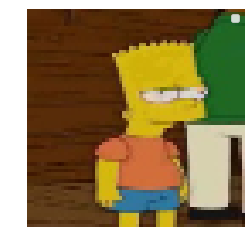

In [11]:
x_train = x_train / 255.0
x_test = x_test / 255.0

visualize_example(x_test[14])

## One hot encoding of labels
- Transformamos las variables para que puedan ser tratadas por la red, convirtiendo un vector de enteros en una matriz de elementos binarios del tipo [0., 0., 0., 0., 0., 0., 0., 1]

In [13]:
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [14]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [54]:
# Manually split training into 20% validation
from sklearn.model_selection import train_test_split
xx_train, xx_validation, yy_train, yy_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=424242)

<hr>

### Fully Conected Network

 - Loss function -> Categorical Crossentropy
 - Optimizer -> Adadelta
 - Topology -> Flattten(64,64,3) -> Dense(512,relu) -> Dense(256,relu) -> Dense(128,relu) -> Dense(64,relu) -> Dense(NUM_CLASSES,softmax)

In [15]:
# Define an earlyStopping callback
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]

model_dense = Sequential()
model_dense.add(Flatten(input_shape=(IMG_SIZE, IMG_SIZE,3)))
model_dense.add(Dense(512, activation='relu'))
model_dense.add(Dense(256, activation='relu'))
model_dense.add(Dense(128, activation='relu'))
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dense(NUM_CLASSES, activation='softmax'))

model_dense.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_dense.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               6291968   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 18)                1170      
Total params: 6,465,618
Trainable params: 6,465,618
Non-trainable para

In [16]:
history_model_dense = model_dense.fit(x_train, y_train,
          batch_size=64,
          epochs=30,
          verbose=1,
          validation_split=0.2,
          callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 15193 samples, validate on 3799 samples
Epoch 1/30
15193/15193 [==============================] - 6s 395us/step - loss: 2.8202 - acc: 0.1403 - val_loss: 2.6514 - val_acc: 0.1537

Epoch 00001: val_acc improved from -inf to 0.15372, saving model to weights-best.hdf5
Epoch 2/30
15193/15193 [==============================] - 4s 263us/step - loss: 2.4303 - acc: 0.2473 - val_loss: 2.1878 - val_acc: 0.3219

Epoch 00002: val_acc improved from 0.15372 to 0.32193, saving model to weights-best.hdf5
Epoch 3/30
15193/15193 [==============================] - 4s 267us/step - loss: 2.2221 - acc: 0.3205 - val_loss: 2.2011 - val_acc: 0.2922

Epoch 00003: val_acc did not improve from 0.32193
Epoch 4/30
15193/15193 [==============================] - 4s 264us/step - loss: 2.0861 - acc: 0.3636 - val_loss: 2.0562 - val_acc: 0.3664

Epoch 00004: val_acc improved from 0.32193 to 0.36641, saving model to weights-best.hdf5
Epoch 5/30
15193/15193 [=========

890/890 [==============================] - 0s 94us/step
Test acc: 0.504
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.64      0.15      0.24        48
  apu_nahasapeemapetilon       0.91      0.40      0.56        50
            bart_simpson       0.22      0.12      0.16        50
charles_montgomery_burns       0.68      0.40      0.50        48
            chief_wiggum       0.79      0.46      0.58        50
          comic_book_guy       0.85      0.47      0.61        49
          edna_krabappel       0.59      0.54      0.56        50
           homer_simpson       0.31      0.44      0.36        50
           kent_brockman       0.85      0.70      0.77        50
        krusty_the_clown       0.73      0.64      0.68        50
            lisa_simpson       0.45      0.42      0.43        50
           marge_simpson       0.59      0.70      0.64        50
     milhouse_van_houten       0.44      0.67      0.53        49
   

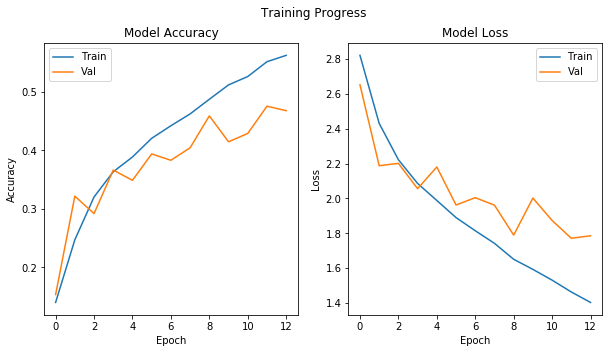

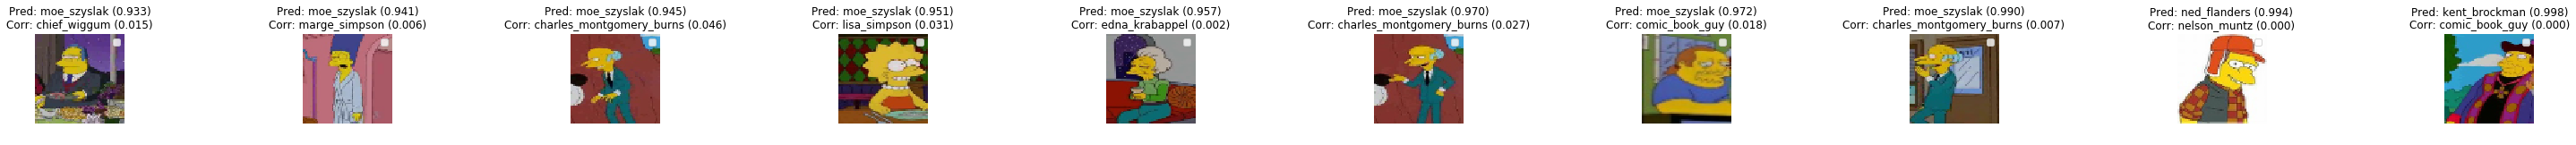

In [17]:
model_dense.load_weights("weights-best.hdf5")

test_loss, test_acc = model_dense.evaluate(x_test, y_test)
print('Test acc: %0.3f' % test_acc)

predicted = model_dense.predict(x_test,verbose=0)
analyze_prediction(history_model_dense, predicted, x_test, y_test, MAP_CHARACTERS)

## Analysis
The model quickly falls into overfitting, so the model seems too powerfull fo the dataset.

Looking at the worst predictions, its difficult to see why the model failed to indentify the target class.

# Data Augmentation
Train the same network but use data augmentation in order to improve generalization.

In [57]:
# Define an earlyStopping callback
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]

model_dense = Sequential()
model_dense.add(Flatten(input_shape=(IMG_SIZE, IMG_SIZE,3)))
model_dense.add(Dense(512, activation='relu'))
model_dense.add(Dense(256, activation='relu'))
model_dense.add(Dense(128, activation='relu'))
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dense(NUM_CLASSES, activation='softmax'))

model_dense.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               6291968   
_________________________________________________________________
dense_51 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_52 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 18)                1170      
Total params: 6,465,618
Trainable params: 6,465,618
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Use data augmentation for training
train_datagen = ImageDataGenerator(
 rotation_range=20, # randomly rotate images in the range
 zoom_range=0.15,
 width_shift_range=0.2, # randomly shift images horizontally 
 height_shift_range=0.2, # randomly shift images vertically 
 horizontal_flip=True, # randomly flip images
 vertical_flip=False)

In [59]:
batch_size = 64
history_model_dense_augmented = model_dense.fit_generator(train_datagen.flow(xx_train, y=yy_train, batch_size=batch_size),
          epochs=30,
          steps_per_epoch=xx_train.shape[0] // batch_size,
          verbose=1,
          validation_data=(xx_validation, yy_validation),
          callbacks=callbacks)

Epoch 1/30
237/237 [==============================] - 15s 62ms/step - loss: 2.8426 - acc: 0.1284 - val_loss: 2.7223 - val_acc: 0.1600

Epoch 00001: val_acc improved from -inf to 0.16004, saving model to weights-best.hdf5
Epoch 2/30
237/237 [==============================] - 13s 53ms/step - loss: 2.6078 - acc: 0.1836 - val_loss: 2.5670 - val_acc: 0.1816

Epoch 00002: val_acc improved from 0.16004 to 0.18163, saving model to weights-best.hdf5
Epoch 3/30
237/237 [==============================] - 13s 55ms/step - loss: 2.5157 - acc: 0.2139 - val_loss: 2.3507 - val_acc: 0.2732

Epoch 00003: val_acc improved from 0.18163 to 0.27323, saving model to weights-best.hdf5
Epoch 4/30
237/237 [==============================] - 13s 54ms/step - loss: 2.4447 - acc: 0.2412 - val_loss: 2.2825 - val_acc: 0.2814

Epoch 00004: val_acc improved from 0.27323 to 0.28139, saving model to weights-best.hdf5
Epoch 5/30
237/237 [==============================] - 14s 60ms/step - loss: 2.3928 - acc: 0.2578 - val_loss

890/890 [==============================] - 0s 111us/step
Test acc: 0.469
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.35      0.25      0.29        48
  apu_nahasapeemapetilon       0.68      0.56      0.62        50
            bart_simpson       0.27      0.44      0.34        50
charles_montgomery_burns       0.60      0.54      0.57        48
            chief_wiggum       0.49      0.48      0.48        50
          comic_book_guy       0.59      0.27      0.37        49
          edna_krabappel       0.69      0.44      0.54        50
           homer_simpson       0.20      0.68      0.31        50
           kent_brockman       0.82      0.64      0.72        50
        krusty_the_clown       0.43      0.64      0.52        50
            lisa_simpson       0.47      0.14      0.22        50
           marge_simpson       0.81      0.68      0.74        50
     milhouse_van_houten       0.44      0.33      0.38        49
  

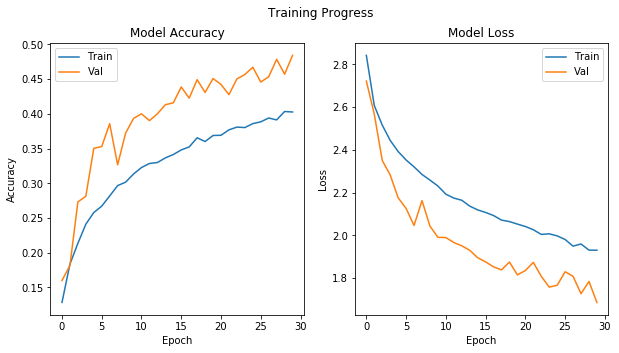

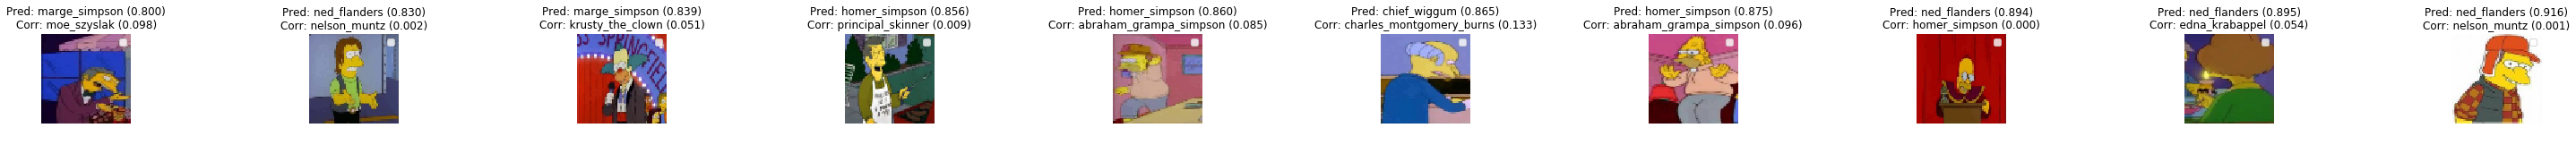

In [60]:
model_dense.load_weights("weights-best.hdf5")

test_loss, test_acc = model_dense.evaluate(x_test, y_test)
print('Test acc: %0.3f' % test_acc)

predicted = model_dense.predict(x_test,verbose=0)
analyze_prediction(history_model_dense_augmented, predicted, x_test, y_test, MAP_CHARACTERS)

## Results
Data augmentation has little effect on the quality of prediction, but added a lot of additional computation time.

Como podemos ver en los resultados, no son buenos, con una media de  0.54 de accuracy,La red es espcialmene buena con Marge y mala con ned_flanders, al comprobar las fotos de test, vemos como marge es claramente diferenciable, por el pelo. Mientras que ned_flanders es en algunas fotos incluso dificil para una persona diferenciarlo

<hr>


### Convolutional neural network


In [29]:
# Define an earlyStopping callback
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]


model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(NUM_CLASSES, activation='softmax'))

model_cnn.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               7372928   
___________________________

In [30]:
model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history_cnn = model_cnn.fit(x_train, y_train,
          batch_size=64,
          epochs=30,
          verbose=1,
          validation_split=0.2, callbacks=callbacks)

Train on 15193 samples, validate on 3799 samples
Epoch 1/30
15193/15193 [==============================] - 12s 804us/step - loss: 2.4895 - acc: 0.2286 - val_loss: 2.0061 - val_acc: 0.3869

Epoch 00001: val_acc improved from -inf to 0.38694, saving model to weights-best.hdf5
Epoch 2/30
15193/15193 [==============================] - 10s 653us/step - loss: 1.9275 - acc: 0.4158 - val_loss: 1.5345 - val_acc: 0.5596

Epoch 00002: val_acc improved from 0.38694 to 0.55962, saving model to weights-best.hdf5
Epoch 3/30
15193/15193 [==============================] - 10s 653us/step - loss: 1.6126 - acc: 0.5062 - val_loss: 1.6742 - val_acc: 0.5154

Epoch 00003: val_acc did not improve from 0.55962
Epoch 4/30
15193/15193 [==============================] - 10s 653us/step - loss: 1.3648 - acc: 0.5823 - val_loss: 1.1211 - val_acc: 0.6631

Epoch 00004: val_acc improved from 0.55962 to 0.66307, saving model to weights-best.hdf5
Epoch 5/30
15193/15193 [==============================] - 10s 653us/step - lo

890/890 [==============================] - 0s 256us/step
Test acc: 0.954
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.92      0.94      0.93        48
  apu_nahasapeemapetilon       1.00      1.00      1.00        50
            bart_simpson       0.92      0.90      0.91        50
charles_montgomery_burns       0.92      0.94      0.93        48
            chief_wiggum       1.00      0.98      0.99        50
          comic_book_guy       0.98      0.88      0.92        49
          edna_krabappel       0.94      0.96      0.95        50
           homer_simpson       0.94      0.98      0.96        50
           kent_brockman       0.98      0.86      0.91        50
        krusty_the_clown       0.93      1.00      0.96        50
            lisa_simpson       0.96      0.86      0.91        50
           marge_simpson       0.98      0.98      0.98        50
     milhouse_van_houten       0.96      0.98      0.97        49
  

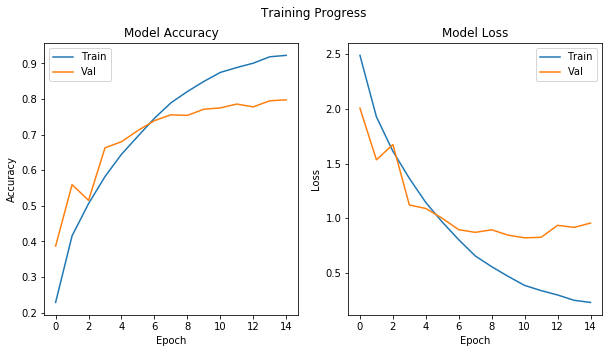

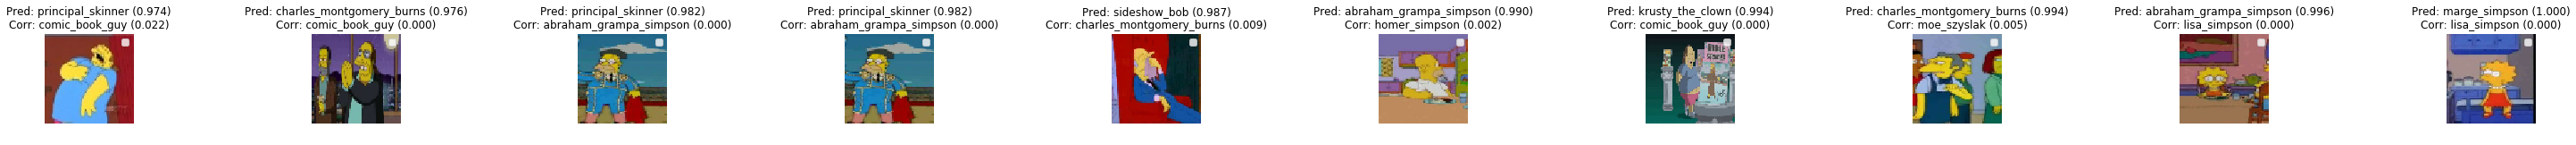

In [31]:
model_cnn.load_weights("weights-best.hdf5")

test_loss, test_acc = model_cnn.evaluate(x_test, y_test)
print('Test acc: %0.3f' % test_acc)

predicted = model_cnn.predict(x_test,verbose=0)
analyze_prediction(history_cnn, predicted, x_test, y_test, MAP_CHARACTERS)

## Results
The trained network achieves a high accuracy on the test set, but starts overfitting early during training. The worst predictions are very off with a high confidence.

# Bigger CCN Model
Try a slightly bigger CNN model, containing more Convolutional layers

In [46]:
# Define an earlyStopping callback
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]

from keras import regularizers
#regularizer=regularizers.l2(0.01)
regularizer=None

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(64,64,3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(Flatten())
#model_cnn.add(Dense(256, activation='relu', kernel_regularizer=regularizer))
#model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation='relu', kernel_regularizer=regularizer))
model_cnn.add(Dropout(0.5))
#model_cnn.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
#model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
model_cnn.add(Dense(NUM_CLASSES, activation='softmax'))

model_cnn.summary()

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 10, 10, 256)       295168    
_________________________________________________________________
flatten_11 (Flatten)         (None, 25600)             0         
__________

In [47]:
history_cnn = model_cnn.fit(x_train, y_train,
          batch_size=64,
          epochs=30,
          verbose=1,
          validation_split=0.2, callbacks=callbacks)

Train on 15193 samples, validate on 3799 samples
Epoch 1/30
15193/15193 [==============================] - 7s 481us/step - loss: 2.6139 - acc: 0.1658 - val_loss: 2.3021 - val_acc: 0.2630

Epoch 00001: val_acc improved from -inf to 0.26296, saving model to weights-best.hdf5
Epoch 2/30
15193/15193 [==============================] - 6s 397us/step - loss: 2.0304 - acc: 0.3430 - val_loss: 1.5397 - val_acc: 0.5109

Epoch 00002: val_acc improved from 0.26296 to 0.51092, saving model to weights-best.hdf5
Epoch 3/30
15193/15193 [==============================] - 6s 394us/step - loss: 1.5901 - acc: 0.4895 - val_loss: 1.2902 - val_acc: 0.6038

Epoch 00003: val_acc improved from 0.51092 to 0.60384, saving model to weights-best.hdf5
Epoch 4/30
15193/15193 [==============================] - 6s 394us/step - loss: 1.2768 - acc: 0.5959 - val_loss: 0.9921 - val_acc: 0.6931

Epoch 00004: val_acc improved from 0.60384 to 0.69308, saving model to weights-best.hdf5
Epoch 5/30
15193/15193 [==================

890/890 [==============================] - 0s 192us/step
Test acc: 0.956
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.88      0.92        48
  apu_nahasapeemapetilon       0.98      1.00      0.99        50
            bart_simpson       0.94      0.96      0.95        50
charles_montgomery_burns       0.96      0.90      0.92        48
            chief_wiggum       1.00      0.96      0.98        50
          comic_book_guy       1.00      0.88      0.93        49
          edna_krabappel       1.00      0.98      0.99        50
           homer_simpson       0.83      0.96      0.89        50
           kent_brockman       0.96      0.90      0.93        50
        krusty_the_clown       0.98      0.98      0.98        50
            lisa_simpson       0.89      0.96      0.92        50
           marge_simpson       0.98      0.98      0.98        50
     milhouse_van_houten       0.96      0.92      0.94        49
  

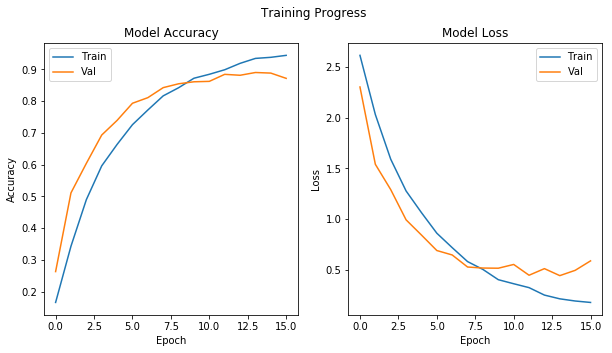

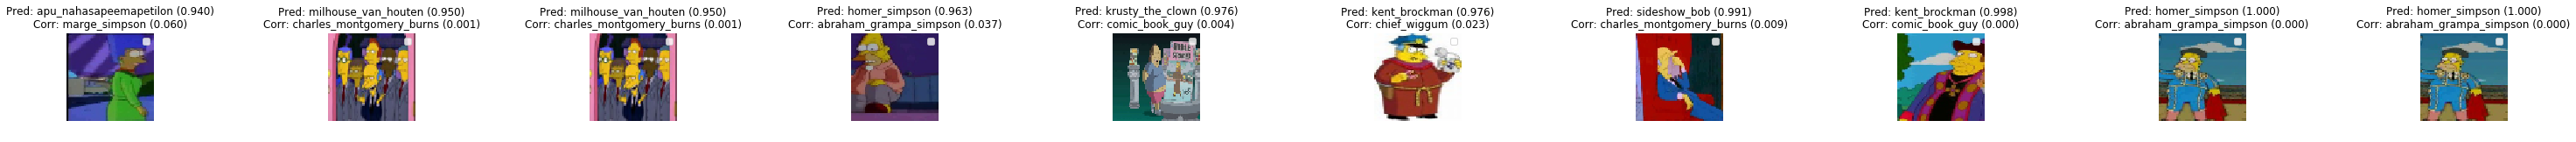

In [48]:
model_cnn.load_weights("weights-best.hdf5")

test_loss, test_acc = model_cnn.evaluate(x_test, y_test)
print('Test acc: %0.3f' % test_acc)

predicted = model_cnn.predict(x_test,verbose=0)
analyze_prediction(history_cnn, predicted, x_test, y_test, MAP_CHARACTERS)

## Results
The test accuracy is not improved, but the network is overfitting later, and maybe generalizes better.

# Data Augmentation
Try the same model bug use data augmentation to increase generalization.

In [55]:
# Define an earlyStopping callback
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]

from keras import regularizers
#regularizer=regularizers.l2(0.01)
regularizer=None

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(64,64,3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(Flatten())
#model_cnn.add(Dense(256, activation='relu', kernel_regularizer=regularizer))
#model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation='relu', kernel_regularizer=regularizer))
model_cnn.add(Dropout(0.5))
#model_cnn.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
#model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
model_cnn.add(Dense(NUM_CLASSES, activation='softmax'))

model_cnn.summary()

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# Use data augmentation for training
train_datagen = ImageDataGenerator(
 rotation_range=10, # randomly rotate images in the range
 zoom_range=0.15,
 width_shift_range=0.2, # randomly shift images horizontally 
 height_shift_range=0.2, # randomly shift images vertically 
 horizontal_flip=True, # randomly flip images
 vertical_flip=False)

batch_size = 64
history_model_dense_augmented = model_cnn.fit_generator(train_datagen.flow(xx_train, y=yy_train, batch_size=batch_size),
          epochs=30,
          steps_per_epoch=xx_train.shape[0] // batch_size,
          verbose=1,
          validation_data=(xx_validation, yy_validation),
          callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 10, 10, 256)       295168    
_________________________________________________________________
flatten_17 (Flatten)         (None, 25600)             0         
__________

890/890 [==============================] - 0s 190us/step
Test acc: 0.935
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.92      0.95        48
  apu_nahasapeemapetilon       0.96      1.00      0.98        50
            bart_simpson       0.94      0.90      0.92        50
charles_montgomery_burns       0.93      0.85      0.89        48
            chief_wiggum       0.94      0.98      0.96        50
          comic_book_guy       0.95      0.78      0.85        49
          edna_krabappel       0.92      0.90      0.91        50
           homer_simpson       0.89      0.94      0.91        50
           kent_brockman       1.00      0.96      0.98        50
        krusty_the_clown       0.98      0.98      0.98        50
            lisa_simpson       0.88      0.92      0.90        50
           marge_simpson       0.94      0.98      0.96        50
     milhouse_van_houten       1.00      0.96      0.98        49
  

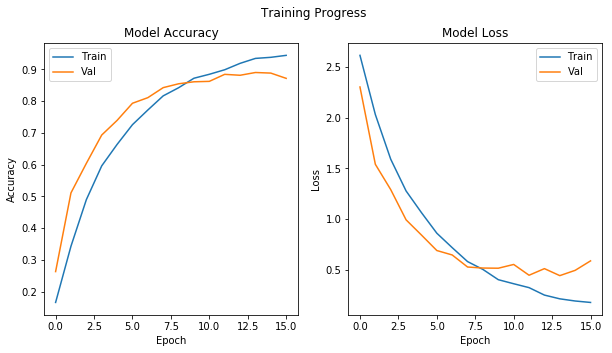

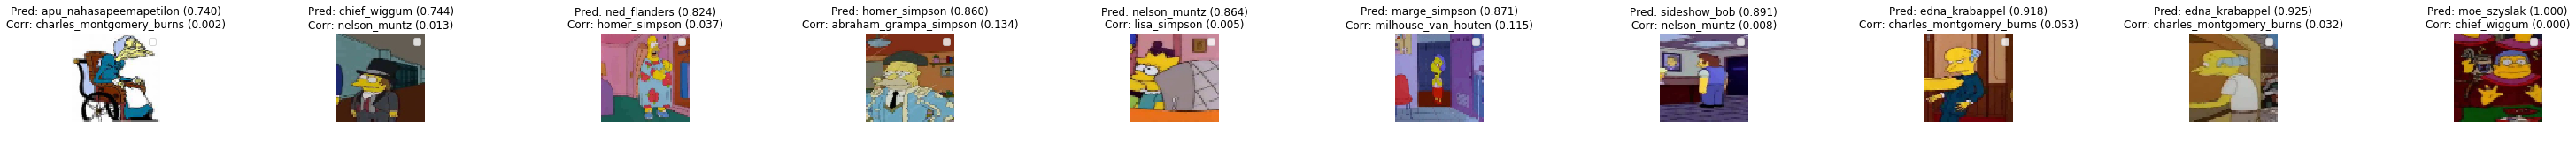

In [56]:
model_cnn.load_weights("weights-best.hdf5")

test_loss, test_acc = model_cnn.evaluate(x_test, y_test)
print('Test acc: %0.3f' % test_acc)

predicted = model_cnn.predict(x_test,verbose=0)
analyze_prediction(history_cnn, predicted, x_test, y_test, MAP_CHARACTERS)

## Results
As in the previous cases, Data Augmentation is not improving the results, but addes significant computation overhead.